<a href="https://colab.research.google.com/github/wang-xianghao/tf-levenberg-marquardt/blob/main/tf-levenberg-marquardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Levenberg-Marquardt
### Install dependencies from GitHub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

os.chdir("/content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

!pip install pip install tensorflow==2.15.0

# Test curve fitting

The function `y = sinc(10 * x)` is fitted using a Shallow Neural Network with 61 parameters.
Despite the triviality of the problem, first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.


_________________________________________________________________
Train using Levenberg-Marquardt
Epoch 1/100


20/20 [==============================] - 3s 100ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 0.0235
Epoch 2/100
20/20 [==============================] - 3s 130ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 0.0029
Epoch 3/100
20/20 [==============================] - 3s 134ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 0.0022
Epoch 4/100
20/20 [==============================] - 4s 196ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 0.0016
Epoch 5/100
20/20 [==============================] - 3s 135ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 0.0014
Epoch 6/100
20/20 [==============================] - 3s 149ms/step - damping_factor: 1.0000e-05 - attempts: 2.0000 - loss: 8.7474e-04
Epoch 7/100
20/20 [==============================] - 2s 86ms/step - damping_factor: 1.0000e-05 - attempts: 3.0000 - loss: 5.8223e-04
Epoch 8/100
20/20 [==============================] - 1s 65ms/step - damping_factor: 1.0000e-05 

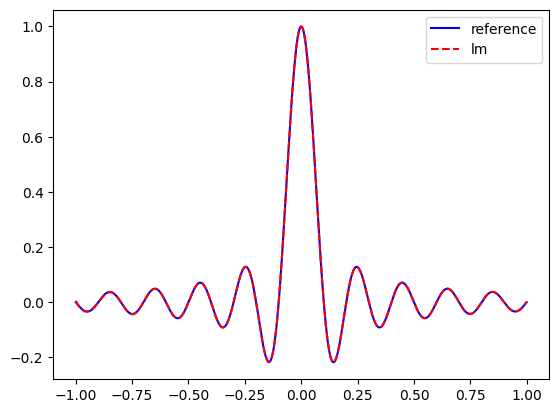

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import levenberg_marquardt as lm

input_size = 20000
batch_size = 1000

x_train = np.linspace(-1, 1, input_size, dtype=np.float64)
y_train = np.sinc(10 * x_train)

x_train = tf.expand_dims(tf.cast(x_train, tf.float32), axis=-1)
y_train = tf.expand_dims(tf.cast(y_train, tf.float32), axis=-1)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(input_size)
train_dataset = train_dataset.batch(batch_size).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(1,)),
    tf.keras.layers.Dense(1, activation='linear')])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError())

model_wrapper = lm.ModelWrapper(
    tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
    loss=lm.MeanSquaredError())

print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=100)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

print("\n_________________________________________________________________")
print("Plot results")
plt.plot(x_train, y_train, 'b-', label="reference")
plt.plot(x_train, model.predict(x_train), 'g--', label="adam")
plt.plot(x_train, model_wrapper.predict(x_train), 'r--', label="lm")
plt.legend()
plt.show()


# Test mnist classification

The classification is performed using a Convolutional Neural Network with 1026 parameters.
This time there were no particular benefits as in the previous case. Even if Levenberg–Marquardt converges with far fewer epochs than Adam, the longer execution time per step nullifies its advantages.
However, both methods achieve roughly the same accuracy values on train and test set.

In [ ]:
import tensorflow as tf
import time
import levenberg_marquardt as lm

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = tf.cast(x_train / 255.0, dtype=tf.float32)
x_test = tf.cast(x_test / 255.0, dtype=tf.float32)

x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(60000)
train_dataset = train_dataset.batch(6000).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='valid',
                           activation='tanh', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=4, strides=2, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Conv2D(filters=4, kernel_size=2, strides=1, padding='valid',
                           activation='tanh'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='linear')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

model_wrapper = lm.ModelWrapper(tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.SparseCategoricalCrossentropy(from_logits=True),
    solve_method='solve',
    metrics=['accuracy'])

print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=200)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)

print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=10)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)

print("\n_________________________________________________________________")
print("Test set results")

test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
print("adam - test_loss: %f - test_accuracy: %f" % (test_loss, test_acc))

test_loss, test_acc = model_wrapper.evaluate(x=x_test, y=y_test, verbose=0)
print("lm - test_loss: %f - test_accuracy: %f" % (test_loss, test_acc))
